In [1]:
from glob import glob
import pandas as pd
import imageio as iio
import matplotlib.pyplot as plt
import numpy as np
import itertools
from skan.csr import skeleton_to_csgraph, make_degree_image, pixel_graph
from skan import Skeleton, summarize, draw
from skan.pre import threshold
import skimage.morphology as sk
from skimage.filters import rank
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
from skimage import io
import os
import shapely

from New_code import spatial_data

In [2]:
def skeletonise(filename, smooth=True, cp=True):
    # Read the line.
    image = io.imread(filename, as_gray=True)
    # Set all active pixels to have value 1.

    image[image < np.mean(image[image > 0])/4] = 0
    image[image > 0] = 1

    if smooth:
 
        #image=sk.binary_dilation(image, footprint=[[0, 0, 1], [0, 1, 0], [1, 0, 0]])
        #image=sk.binary_dilation(image, footprint=[[1, 0, 0], [0, 1, 0], [0, 0, 1]])
        image = sk.binary_dilation(image)
        #image = sk.binary_dilation(image, footprint=sk.disk(2))
        
    # 
    #image = threshold(image, sigma=1, radius=int((image.shape[0])/5))
    image = sk.binary_closing(image)

    if smooth:
        image = sk.skeletonize(image, method='lee')
    if not smooth:
        image = sk.medial_axis(image, return_distance=False)
    

    pixel_graph, coordinates = skeleton_to_csgraph(image)
    branch_data = summarize(Skeleton(image))
    return image, branch_data




In [3]:
def extract_edges_verts(data):
    data_internal=data[data['branch-type']==2] #do we also need to split out sub skeletons for disconnected traces? We also want to identify holes by number of cycles compared to Nc, if cycles < Nc then there is a hole and can't get matrices.
    data_int=data_internal.drop_duplicates().reset_index(drop=True)
    
    #find unique vertices
    src=data_int[['node-id-src', 'image-coord-src-1', 'image-coord-src-0']].drop_duplicates()
    dst=data_int[['node-id-dst', 'image-coord-dst-1', 'image-coord-dst-0']].drop_duplicates()

    src=src.rename(columns={'node-id-src':'node_id', 'image-coord-src-1':'x', 'image-coord-src-0':'y'})
    dst=dst.rename(columns={'node-id-dst':'node_id', 'image-coord-dst-1':'x', 'image-coord-dst-0':'y'})

    node_coords=pd.concat([src,dst]).drop_duplicates().reset_index(drop=True)
    nodes=np.array(sorted(node_coords['node_id']))
   
    #edges as vertex pairs
    edge_verts=np.array(data_int[['node-id-src', 'node-id-dst']])
    
    #re index nodes
    new_nodes=np.linspace(0,len(node_coords)-1, len(node_coords)).astype(int)
    node_map = {nodes[i]: new_nodes[i] for i in range(len(new_nodes))}
    node_coords['node_id']=[node_map[x] for x in node_coords['node_id']]
    n_coords=np.array(node_coords.sort_values(by=['node_id']).iloc[:,1:]) #image coordinates of nodes
    
    #use map to reindex list of verices connected to an edge

    edge_verts[:,0]=[node_map[x] for x in edge_verts[:,0]]
    edge_verts[:,1]=[node_map[x] for x in edge_verts[:,1]]

    edge_verts=np.sort(edge_verts, axis=1) #orientate edges
    
    return edge_verts, n_coords



In [4]:
def construct_ev_incidence_matrix(edge_verts, Ne, Nv):
    #Find the edge-vetex incidence matrix A_jk

    A=np.zeros((Ne,Nv))


    for j in range(0,Ne):
        A[j][edge_verts[j, 0]]=-1 #flows out of vertex
        A[j][edge_verts[j, 1]]=1 #flows into vertex
        
    return A



In [5]:
def construct_adjacency_matrix(A):
    Adj=np.dot(np.transpose(abs(A)),abs(A)) #create vertex-vertex adjacency matrix
    Adj[np.where(Adj>1)]=0
    Adj_sp=csr_matrix(Adj)
    G = nx.from_scipy_sparse_array(Adj_sp) #create networkx graph object from sparse adjacency matrix
    
    return G



In [6]:
def get_cycles(G, n_threshold, R):
       #For small graphs we can use the minimum_cycle_basis function below, but it is very very slow for most images:
    #cells=nx.minimum_cycle_basis(G)

    cycles=list(nx.simple_cycles(G, 12))
    
    #remove duplicates (cells share 1 edge/2 vertices)
  
    c=sorted(list(cycles for cycles,_ in itertools.groupby(cycles)), key=len) 
    cells=[c[0]]
    for i in c:
         if all([len(set(i).intersection(x))<3 for x in cells]):
                cells.append(i)
                
                
    cell_orientation=[shapely.Polygon(R[cells[x]]).exterior.is_ccw for x in range(len(cells))]
    cells=[cells[x][::-1] if cell_orientation[x] else cells[x] for x in range(len(cells))]

    
    return cells



In [7]:
def assign_edges_to_cells(cells, edge_verts, Ne):
    #edge indexs in each cell.
    cell_edges={}
    for i in range(len(cells)):
        for j in range(Ne):
            if(set(edge_verts[j]).issubset(cells[i])):
                if i in cell_edges.keys():
                    cell_edges[i]=list(set(cell_edges[i]).union([j]))
                else:
                    cell_edges[i]=[j]
    return cell_edges



In [8]:
def get_edge_cells(cells, edge_verts,Ne):
    #get edges connected to each cell, 1 for peripheral edges, 2 for other edges
    edge_cells={}
    for i in range(len(cells)):
        for j in range(Ne):
            if(set(edge_verts[j]).issubset(cells[i])):
                if j in edge_cells.keys():
                    edge_cells[j]=list(set(edge_cells[j]).union([i]))
                else:
                    edge_cells[j]=[i]
    return edge_cells



In [16]:
pos = {i: R[i] for i in range(Nv)}
pos

NameError: name 'Nv' is not defined

In [17]:
nx.draw(G, pos=pos)  # networkx draw()

plt.draw() 

NameError: name 'G' is not defined

In [18]:
H=nx.DiGraph([tuple(edge_verts[x]) for x in range(len(edge_verts))])

NameError: name 'edge_verts' is not defined

In [19]:

nx.draw_networkx_edges(G, pos, alpha=1)
nx.draw_networkx_edges(H, pos, alpha=1)

NameError: name 'G' is not defined

In [9]:
def construct_ce_incidence_matrix(cells,edge_verts, Nc, Ne, A):  
    B=np.zeros((Nc,Ne))

    for i in range(0,Nc): #loop over cells
    
        for j in range(len(cells[i])): #loop over cell list
            
            edge=list(set(np.argwhere(A[:,cells[i][j-1]]).flatten()).intersection(np.argwhere(A[:,cells[i][j]]).flatten()))[0]

            if edge_verts[edge,1]==cells[i][j]:
                B[i, edge]=1
            else:
                B[i, edge]=-1

    return B



In [10]:
def get_interior_cells(cells, edge_cells, cell_edges, edge_verts, n_coords):
    b_cells=[edge_cells[edge][0] for edge in edge_cells if len(edge_cells[edge])==1] #boundary cells
    l_cells=np.linspace(0, len(cells)-1,len(cells) ).astype(int)
    
    interior_cells=[cells[i] for i in l_cells if i not in set(b_cells)]
    interior_cell_edges=[cell_edges[i]for i in l_cells if i not in set(b_cells)]
    
    int_vertices=np.unique([x for sublist in interior_cells for x in sublist])
    int_edges=np.unique([x for sublist in interior_cell_edges for x in sublist])
    
    int_edge_verts=edge_verts[sorted(int_edges)]
    int_n_coords=n_coords[sorted(int_vertices)]

    #re index  and edges
    nodes=sorted(int_vertices)
    new_nodes=np.linspace(0,len(int_vertices)-1, len(int_vertices)).astype(int)
    node_map = {nodes[i]: new_nodes[i] for i in range(len(new_nodes))}
    
    edges=sorted(int_edges)
    new_edges=np.linspace(0,len(int_edges)-1, len(int_edges)).astype(int)
    edge_map = {edges[i]: new_edges[i] for i in range(len(new_edges))}


    int_edge_verts[:,0]=[node_map[x] for x in int_edge_verts[:,0]]
    int_edge_verts[:,1]=[node_map[x] for x in int_edge_verts[:,1]]

    int_cells=[[node_map[x] for x in sublist]for sublist in interior_cells]
    int_cell_edges=[[edge_map[x] for x in sublist]for sublist in interior_cell_edges]
    
    return int_cells,int_cell_edges, int_edge_verts, int_n_coords

1307 1908 602


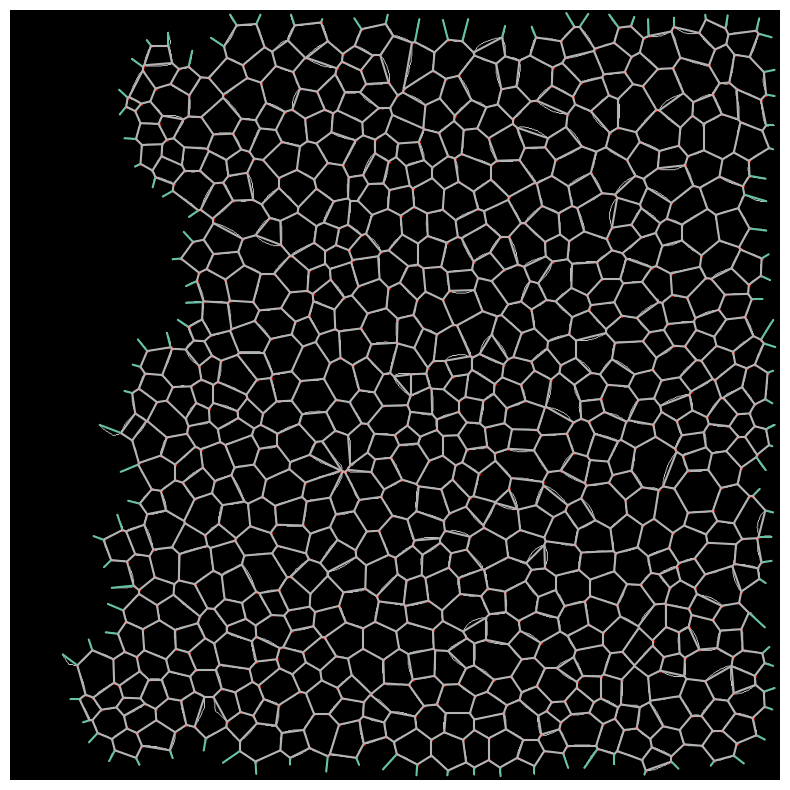

In [11]:
edges_file='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Parameter_Inference\\Traces/20231024_2_IP_GFPCAAX-CheHis_uu_0p5_MP_fr6_trace.tif'
image0 = iio.v2.imread(edges_file)
#skeletonise and segment edges
im, data=skeletonise(edges_file, cp=False)
#remove spiderlegs/contractible branches
edge_verts, n_coords=extract_edges_verts(data)

Nv=len(n_coords)
Ne=len(edge_verts)
Nc=2+Ne-Nv-1 #Euler characteristic for a planar graph minus the outside infinite face.
print(Nv, Ne, Nc)

fig, ax=plt.subplots(figsize=(10,10))
ax.imshow(im)
ax.scatter(n_coords[:,0], n_coords[:,1], s=1, c='r')

draw.overlay_euclidean_skeleton_2d(im,data,
                                   skeleton_color_source='branch-type', skeleton_colormap='Set2', axes=ax);

In [12]:
R=np.transpose(np.vstack((n_coords[:,0],n_coords[:,1])))


A=construct_ev_incidence_matrix(edge_verts, Ne, Nv)
    
#construct graph from edgelist
G=nx.Graph([tuple(edge_verts[x]) for x in range(len(edge_verts))])

cells=get_cycles(G, 12, R)

if len(cells)!=Nc: print("Nc-len(cells) = ", Nc-len(cells))

B=construct_ce_incidence_matrix(cells,edge_verts, Nc, Ne, A)

if len(np.where(B@A!=0)[0])!=0: print("Matrix generation error, check A and B")
    
C=0.5*(abs(B)@abs(A))


In [14]:
np.sort(spatial_data.get_areas(A, B, R))


array([ 217. ,  342. ,  346. ,  428. ,  472. ,  478.5,  532.5,  536. ,
        541. ,  541. ,  544. ,  551. ,  562.5,  570.5,  580. ,  597.5,
        620. ,  643.5,  645.5,  651.5,  656.5,  672. ,  695. ,  701.5,
        703.5,  704. ,  705. ,  706. ,  706.5,  712.5,  718. ,  722.5,
        732. ,  736.5,  741. ,  741.5,  743. ,  743.5,  746. ,  747.5,
        752.5,  753.5,  754. ,  761.5,  767. ,  782. ,  783. ,  800.5,
        801. ,  803.5,  807. ,  807.5,  810.5,  814. ,  819. ,  819. ,
        821. ,  822. ,  824.5,  826. ,  832.5,  835. ,  839.5,  844.5,
        846. ,  846.5,  847. ,  847.5,  848. ,  848.5,  849.5,  850.5,
        854.5,  861.5,  863. ,  866. ,  867.5,  871.5,  872. ,  872.5,
        873.5,  875.5,  876. ,  878. ,  882.5,  883. ,  886.5,  887.5,
        887.5,  889. ,  890. ,  890.5,  891. ,  894. ,  896.5,  899.5,
        902. ,  902.5,  902.5,  904. ,  905.5,  910. ,  910.5,  918. ,
        924.5,  926. ,  930.5,  930.5,  931.5,  933. ,  933.5,  934. ,
      

In [19]:
np.array([shapely.Polygon(R[cells[x]]).area for x in range(len(cells))])

array([ 732. ,  643.5,  736.5,  704. ,  346. ,  532.5,  580. ,  342. ,
        472. ,  428. ,  541. ,  718. ,  924.5, 1094.5,  783. , 1398. ,
       1485.5,  955. ,  807.5, 1004. , 1058.5,  878. , 1323. , 1148. ,
       1034. , 1116. , 1149. ,  850.5,  977.5,  883. ,  217. , 1344.5,
       1117. , 1566. ,  645.5, 1515.5, 1185. , 1411.5,  876. , 1490. ,
        866. ,  761.5,  902.5, 1222. , 1057. , 1149. , 1396. , 1015. ,
       1580.5,  846.5,  706.5, 1430. ,  977.5, 1337.5, 1037. ,  998.5,
       1199. ,  741.5, 1189.5, 1092. ,  887.5,  955.5, 1627.5, 1351. ,
       1290.5, 1096.5,  752.5,  962. ,  933. , 1060.5,  956. ,  541. ,
        889. ,  695. , 1220. , 1007.5, 1688. ,  846. , 1014. , 1061. ,
        747.5,  875.5,  705. ,  871.5,  656.5,  562.5,  741. ,  993.5,
       1151. ,  994.5, 1284. ,  651.5,  863. ,  839.5,  551. ,  939.5,
       1376. , 1079.5, 1060. ,  992. , 1086. ,  986.5,  934. , 1420.5,
        753.5, 1237.5,  902.5, 1372.5,  930.5, 1121.5,  939. ,  478.5,
      